In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/vi_search/python

/content/drive/MyDrive/vi_search/python


In [ ]:
!ls

sample_data


In [ ]:
%cd data


/content/drive/MyDrive/vi_search/python/data


# Dataset


In [ ]:
import numpy as np
import  torch.nn.functional as F
import cv2
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pickle

In [ ]:
import torchvision.models as models
import torch
import torch.nn as nn


def replace_layers(model, old, new):
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            ## compound module, go inside it
            replace_layers(module, old, new)

        if isinstance(module, old):
            ## simple module
            try:
                n = int(n)
                model[n] = new
            except:
                setattr(model, n, new)


model_stim = models.vgg16(pretrained=True).features[:-1]
model_target = models.vgg16(pretrained=True).features
replace_layers(
    model_stim,
    nn.MaxPool2d,
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
)

replace_layers(
    model_target,
    nn.MaxPool2d,
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True),
)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:


TotalTrials = 600
targetsize = 28
stimulisize = 224

In [ ]:
transform_target = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((targetsize, targetsize)),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),transforms.ConvertImageDtype(torch.float)]
)

transform_source = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((stimulisize, stimulisize)),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),transforms.ConvertImageDtype(torch.float)]
)

# mean = torch.FloatTensor([103.939, 116.779, 123.68]).view(3, 1, 1)


def preprocess(img, name="src"):
    if name == "src":
        size = transform_source(img).size()
        return torch.unsqueeze(transform_source(img)*256,dim=0) #- mean.expand(size),
    else:
        size = transform_target(img).size()
        return torch.unsqueeze(transform_target(img)*256,dim=0) # - mean.expand(size),dim=0)



In [ ]:
folder_stimuli = "stimuli/"
folder_target = "target/"

    

In [ ]:
model_stim.cuda()
model_target.cuda()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_size=

In [ ]:
model_stim.eval()
model_target.eval()
stack=dict()

In [ ]:

target_ims = dict()
for i in range(len(os.listdir('target'))//2):
    target_ims[i] = model_target(preprocess(cv2.imread(folder_target + f"target_{i+1}.jpg"),'tar').cuda())

In [ ]:
stim_ims =dict()
for i in range(len(os.listdir('stimuli'))):
    k=cv2.imread(folder_stimuli + f"array_{i+1}.jpg")
    im_tens=preprocess(k,'src')
    stim_ims[i]=im_tens

In [ ]:
for i in range(len(os.listdir('stimuli'))):
  with torch.no_grad():
    stim_ims[i] = model_stim(stim_ims[i].cuda())

In [ ]:
for idx in range(len(os.listdir('stimuli'))):
  
  
  stack[idx]=dict()
  for i,j in target_ims.items():
   
    out_tens = F.conv2d(
        stim_ims[idx],j, None, (1, 1), (1, 1)
    ) 
    out_tens = torch.squeeze(out_tens,dim=0)
    stack[idx][i]=[]
    stack[idx][i].append(out_tens.cpu().detach().numpy())
  if idx%50 ==0:
    print(f'Done with {idx} stim ims')


Done with 0 stim ims
Done with 50 stim ims
Done with 100 stim ims
Done with 150 stim ims
Done with 200 stim ims
Done with 250 stim ims


In [ ]:
import pylab as plt

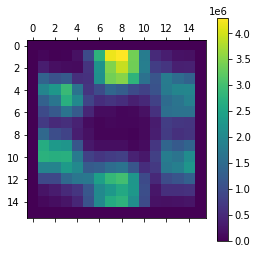

In [ ]:
plt.matshow(np.array(stack[2][2]).squeeze().reshape(16,16))
plt.colorbar()

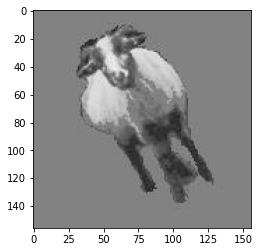

In [ ]:
plt.imshow(cv2.imread('target/target_3.jpg'))

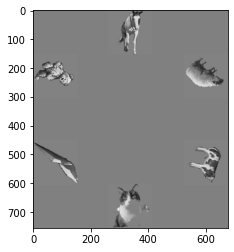

In [ ]:
plt.imshow(cv2.imread('stimuli/array_3.jpg'))

In [ ]:
z= pickle.load(open('/content/drive/MyDrive/vi_search/python/data/gtpos.pkl','rb'))

In [ ]:
z[10%6][10]

array([1])

In [ ]:
pickle.dump(stack,open('../att_maps.pkl','wb'))

In [ ]:
k = pickle.load(open('/content/drive/MyDrive/vi_search/python/att_map.pkl','rb'))

# Get results

In [ ]:
import pickle
f=pickle.load(open('att_maps.pkl','rb'))

In [ ]:
def gray(img):
    img=np.array(img)
    return img/img.max().max()

In [ ]:
import cv2
from tqdm import tqdm
from scipy.io import loadmat
import numpy as np
import pylab as plt

In [ ]:
gtpos = pickle.load(open('gtpos.pkl','rb'))

In [ ]:
num_cates=6
num_ims=300
x= loadmat('./eval/saliencyMask/maskind.mat')
total_mask = x['maskind']
masks= dict()
for i in range(1,7):
    
    masks[i] = loadmat(f'./eval/saliencyMask/mask{i}.mat')['mask']
    

In [ ]:
attmaps= dict()
for i in range(num_ims):
    
    attmaps[i] = gray(cv2.resize(np.squeeze(f[i][i][0]), total_mask.T.shape))

In [ ]:
def search(size,arr,x,y):
  l = np.zeros((size,size))
  for i in range(-size//2,size//2):
    for j in range(-size//2,size//2):
      l[i][j] = arr[x-int(i)][y-int(j)]
      if l[i][j]!=0:
        return (i,j)

    # return np.unravel_index(np.arg_sort(l)[0],shape = arr.shape)
  

In [ ]:
print(search(40,total_mask,195,50))

(-20, -20)


In [ ]:
posx=dict()
posy=dict()
for i in range(num_ims):
  posx[i] =[]
  posy[i]=[]

In [ ]:
scorematrix = np.zeros(num_ims)
for i in range(num_ims):
    if i%100==0:
        print(f'done with {i}')
    att_map = attmaps[i]
    for j in range(num_cates):
        if j==0:
            salimg = np.multiply(att_map,total_mask)
        else:
            chosenmask = masks[chosenfix]
            temp = np.multiply(salimg,(1-chosenmask))
            salimg = gray(temp)

      
        indx,indy = np.unravel_index(np.argmax(salimg),shape = salimg.shape)
        
        

        chosenfix = total_mask[indx,indy]
        posx[i].append(indx)
        posy[i].append(indy)
          
        scorematrix[i] +=1
        if gtpos[i%6][i]+1 == chosenfix:
            break

done with 0
done with 100
done with 200


In [ ]:
import matplotlib.lines as mlines


In [ ]:
print(posy[1])
total_mask[212,147]

[528, 317, 147]


2

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
# @interact(num=(0,299))
def plot_scanpath(num):
  f,(a1,a2) = plt.subplots(1,2,figsize=(20,10))
  im1 = cv2.resize(cv2.imread(f'/content/drive/MyDrive/vi_search/python/data/stimuli/array_{num+1}.jpg'),total_mask.T.shape)
  a1.imshow(im1)
  a1.matshow( np.multiply(attmaps[num],total_mask),cmap='jet', alpha=0.5)
  # plt.colorbar()
  for i,j in enumerate(posx[num]):
    a1.text(j,posy[num][i],f'{i}',fontsize = 20, color='y')

  if len(posx[num])>0:
    for i in range(len(posx[num])-1):
      l = mlines.Line2D([posx[num][i],posx[num][i+1]], [posy[num][i],posy[num][i+1]],color='g')
      a1.add_line(l)
  im2 = cv2.resize(cv2.imread(f'/content/drive/MyDrive/vi_search/python/data/target/target_{num+1}.jpg'),total_mask.T.shape)
  a2.imshow(im2)
  

In [ ]:
gtpos[2][2]

array([3])

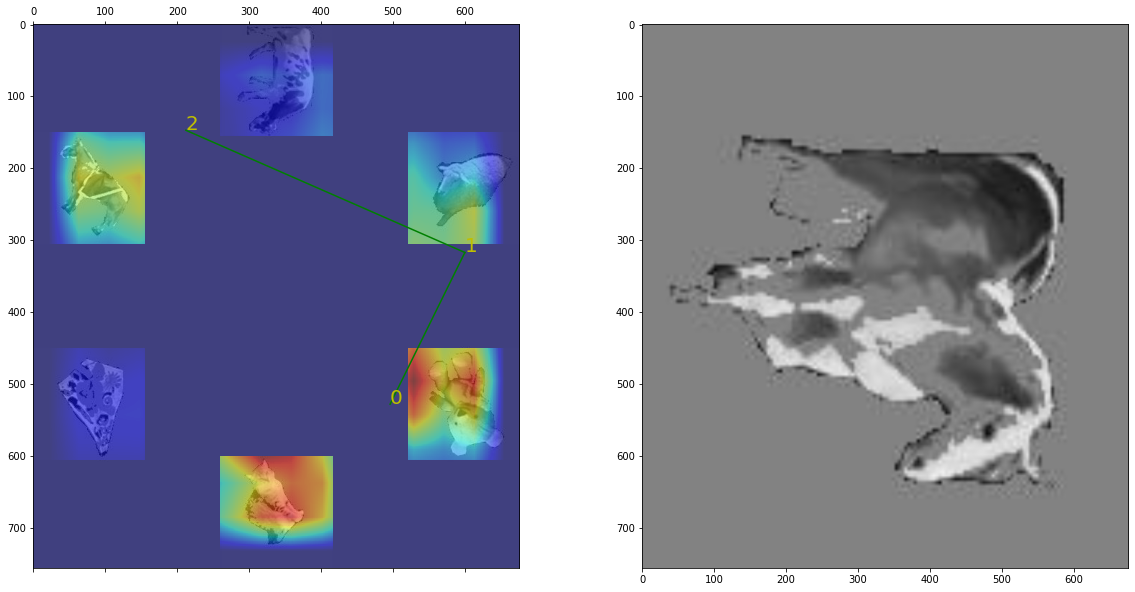

In [ ]:
plot_scanpath(1)

In [ ]:
from sys import platform
def plot_scanpath_fig(num):
  # f,(a1,a2) = plt.subplots(1,2,figsize=(20,10))
  plt.figure(1,figsize=(20,10))
  im1 = cv2.resize(cv2.imread(f'/content/drive/MyDrive/vi_search/python/data/stimuli/array_{num+1}.jpg'),total_mask.T.shape)
  plt.imshow(im1)
  ax=plt.gca()
  ax.matshow(np.multiply(attmaps[num],total_mask),cmap='plasma', alpha=0.5)
  ax.colorbar()
  
  for i,j in enumerate(posx[num]):
    ax.text(j,posy[num][i],f'{i}',fontsize = 10, color='g')

  if len(posx[num])>0:
    for i in range(len(posx[num])-1):
      l = mlines.Line2D([posx[num][i],posx[num][i+1]], [posy[num][i],posy[num][i+1]],color='g')
      ax.add_line(l)
  
  plt.figure(2,figsize=(20,10))
  im2 = cv2.resize(cv2.imread(f'/content/drive/MyDrive/vi_search/python/data/target/target_{num+1}.jpg'),total_mask.T.shape)
  plt.imshow(im2)
  plt.show()

AttributeError: ignored

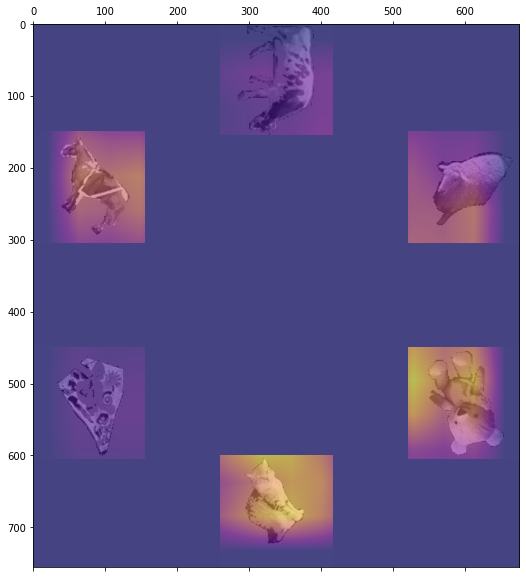

In [ ]:
plot_scanpath_fig(1)

(array([56.,  0., 56.,  0., 53.,  0., 43.,  0., 44., 48.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

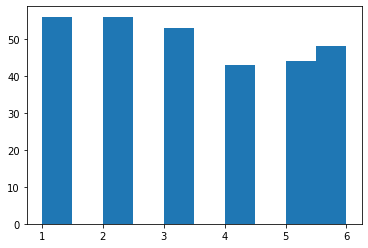

In [ ]:
# (a,b,c) = plt.hist(scorematrix, bins=10)
# plt.plot(b[:10],np.cumsum(a/300))
# plt.xlabel('numer of fixations')
# plt.ylabel('Probability')
# plt.title('Cumulative Probaility')

In [ ]:
scorematrix

array([6., 3., 4., 6., 3., 5., 3., 1., 1., 4., 5., 1., 4., 2., 6., 4., 6.,
       4., 5., 1., 6., 2., 5., 4., 1., 2., 3., 5., 2., 5., 4., 2., 6., 3.,
       6., 3., 3., 4., 1., 5., 2., 3., 5., 2., 2., 3., 4., 5., 4., 2., 1.,
       1., 5., 5., 6., 2., 1., 2., 1., 6., 3., 2., 2., 1., 6., 3., 4., 3.,
       6., 3., 2., 4., 4., 5., 4., 2., 4., 5., 1., 5., 2., 1., 5., 3., 4.,
       3., 1., 1., 2., 4., 6., 6., 1., 1., 3., 2., 3., 3., 2., 3., 4., 5.,
       5., 4., 3., 5., 5., 5., 4., 5., 4., 4., 6., 1., 3., 5., 2., 6., 2.,
       3., 2., 3., 2., 2., 3., 4., 1., 3., 2., 1., 4., 3., 4., 2., 6., 2.,
       5., 1., 4., 3., 3., 6., 6., 1., 4., 3., 6., 6., 5., 1., 4., 2., 2.,
       4., 5., 5., 1., 6., 5., 3., 1., 2., 6., 3., 1., 5., 1., 3., 3., 6.,
       2., 2., 5., 2., 6., 6., 6., 5., 1., 5., 1., 5., 2., 1., 6., 6., 1.,
       2., 2., 1., 1., 4., 2., 1., 3., 6., 1., 5., 5., 1., 3., 2., 6., 5.,
       6., 4., 5., 6., 5., 2., 6., 6., 4., 6., 6., 3., 1., 2., 1., 3., 3.,
       1., 4., 1., 4., 1.

In [ ]:
np.mean(np.array(scorematrix))

3.3566666666666665